# Deep Learning Portfolio 1

|Name|Github|Kaggle|
|----|------|------|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Michal Reszka-Gniecki|Ckires|michalreszkagniecki|

## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Visualiseren](#visualiseren)
- [Feature Engineering](#feature-engineering)
    - [Analysis](#analysis)
- [Modeling](#modeling)
    - [Fully-connected neuraal netwerk](#Model1)
    - [Convolutioneel neuraal netwerk from scratch](#Model2)
    - [Transfer learning](#Model3)
    - [Multimodaal mode](#Model4)
- [Results](#results)
    - [Overview](#overview)
    - [Scores](#scores)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Data Overview

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Data importeren

In [3]:
train_numeriek_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 1 Datasets/train.csv')
test_numeriek_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 1 Datasets/test.csv')

In [4]:
img_train_directory = "/content/drive/MyDrive/Colab Notebooks/Portfolio 1 Datasets/Train"
img_test_directory = "/content/drive/MyDrive/Colab Notebooks/Portfolio 1 Datasets/Test"

## Exploratory Data Analysis

Alle JPEG-afbeeldingen uit de opgegeven map Train en Test worden geladen en opgeslagen in twee lijsten.

In [5]:
image_paths = tf.io.gfile.glob(img_train_directory + '/*.jpg')
train_images = []
for path in image_paths:
    image_raw = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_raw)
    train_images.append(image)

In [6]:
image_paths_test = tf.io.gfile.glob(img_test_directory + '/*.jpg')
test_images = []
for path in image_paths_test:
    image_raw = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_raw)
    test_images.append(image)

Het aantal geladen afbeeldingen in de datasets train_images en test_images wordt weergegeven.

In [7]:
print(f"Aantal geladen afbeeldingen: {len(train_images)}")
print(f"Aantal geladen afbeeldingen: {len(test_images)}")


Aantal geladen afbeeldingen: 500
Aantal geladen afbeeldingen: 35


De vormen (shapes) van de afbeeldingen in de train_images dataset worden geanalyseerd, waarbij alle unieke afbeeldingsformaten worden weergegeven.

In [8]:
image_shapes = [image.shape for image in train_images]
# Om alle unieke shapes te zien:
print(f"Unique shapes : {set(tuple(shape) for shape in image_shapes)}")

Unique shapes : {(1024, 1024, 3)}


De vorm (shape) van de eerste afbeelding in de train_images dataset wordt hiermee weergegeven.

In [9]:
print(f"Image shape: {train_images[0].shape}") # geeft de shape van de eerste image (H, W, C)
# het laatste getal in de shape is het aantal kleurkanalen

Image shape: (1024, 1024, 3)


## Voorbeeld van trainings- en testafbeeldingen

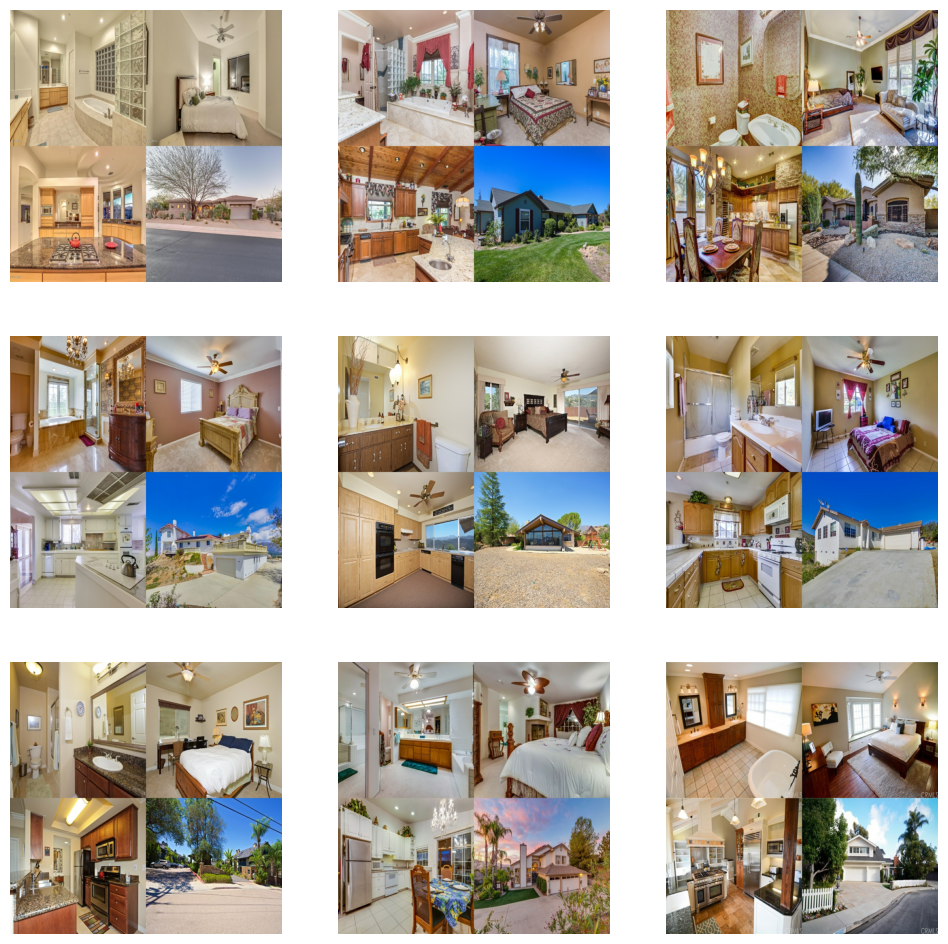

In [10]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i].numpy())
    plt.axis("off")
plt.show()

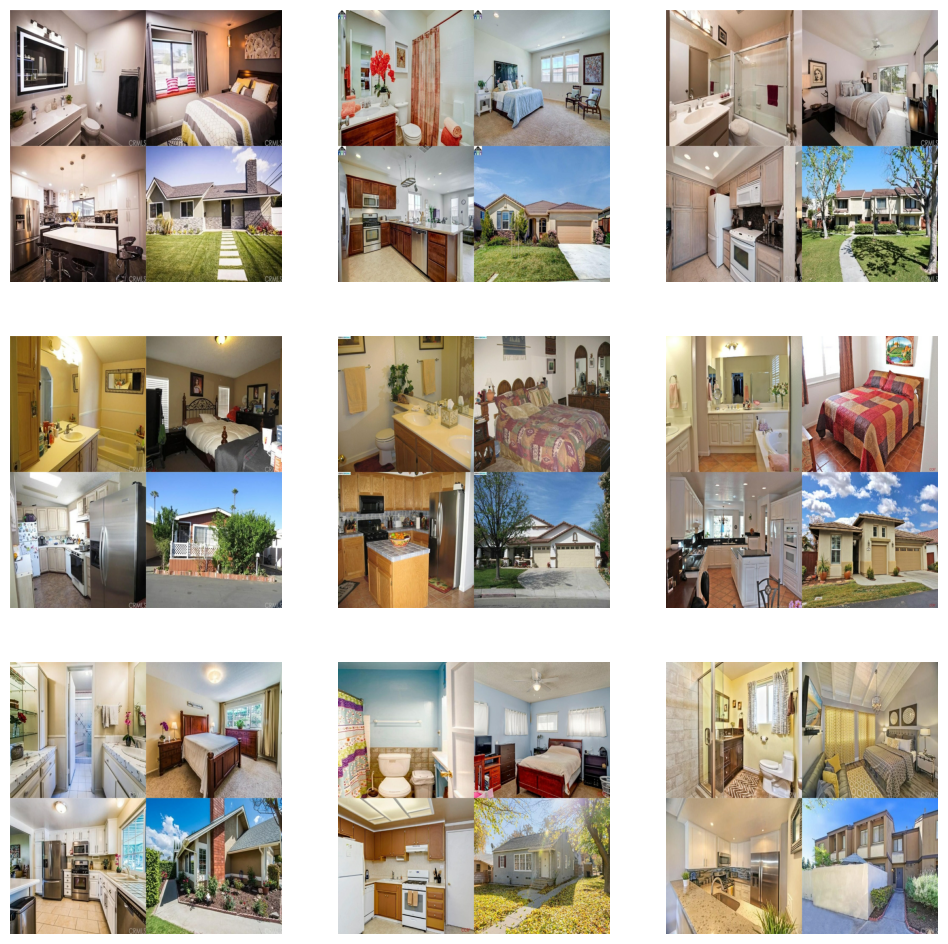

In [11]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].numpy())
    plt.axis("off")
plt.show()

De grafiek toont de verdeling van pixelwaarden voor de kleuren rood, groen en blauw in de afbeeldingen.

Mean pixel values: [142.74492561 133.55400624 119.70312065]


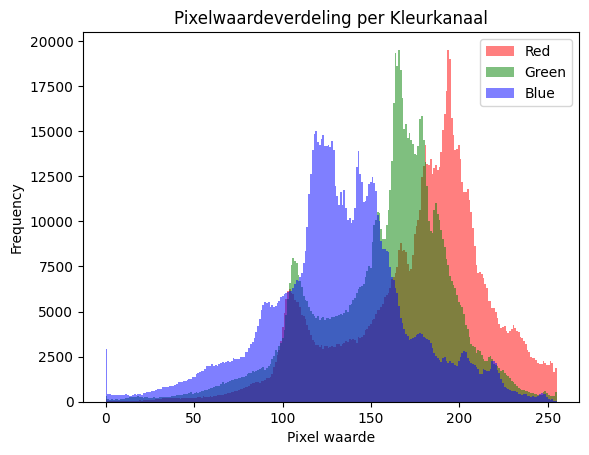

In [12]:
# Converteer images naar NumPy arrays
image_arrays = [image.numpy() for image in train_images]

# Bereken de gemiddelde pixelwaarde per kanaal
mean_pixel_values = np.mean(image_arrays, axis=(0, 1, 2))
print(f"Mean pixel values: {mean_pixel_values}")

# Plot histogrammen van pixelwaarden per kanaal
plt.hist(image_arrays[0][:, :, 0].flatten(), bins=256, color='red', alpha=0.5, label='Red')
plt.hist(image_arrays[0][:, :, 1].flatten(), bins=256, color='green', alpha=0.5, label='Green')
plt.hist(image_arrays[0][:, :, 2].flatten(), bins=256, color='blue', alpha=0.5, label='Blue')
plt.legend()
plt.title('Pixelwaardeverdeling per Kleurkanaal')
plt.xlabel('Pixel waarde')
plt.ylabel('Frequency')
plt.show()

De x-as vertegenwoordigt de pixelwaarden, die variëren van 0 tot 250, en de y-as geeft het aantal pixels weer voor elke waarde.

Uit de grafiek kunnen we afleiden hoe de intensiteit van elke kleur is verdeeld over de afbeelding. Als een bepaalde kleur een hogere piek heeft bij specifieke pixelwaarden, betekent dit dat die kleurintensiteit vaker voorkomt in de afbeeldingen.

De rode piek is het hoogst, gevolgd door groen en daarna blauw. Dit kan helpen om de kleurbalans en de algemene toon van de afbeelding te begrijpen. Een dominante rode piek kan wijzen op een warmere kleurtemperatuur in de afbeelding
.

In [13]:
display(train_numeriek_df.head())
display(test_numeriek_df.head())

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
0,1,4,4.0,4053,33.6968,-111.8892,869500
1,2,4,3.0,3343,34.8280,-119.0349,865200
2,3,3,4.0,3923,33.7669,-111.9182,889000
3,4,5,5.0,4022,33.7752,-111.7791,910000
4,5,3,4.0,4116,33.7669,-111.9182,971226


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude
0,501,3,2.0,2330,35.6406,-120.7003
1,502,3,2.5,1339,35.6406,-120.7003
2,503,3,2.0,1472,35.6406,-120.7003
3,504,4,4.0,2681,35.6406,-120.7003
4,505,3,2.5,1935,33.8085,-117.9228


###Datatype

In [ ]:
train_numeriek_df.info()
test_numeriek_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   500 non-null    int64  
 1   Bedrooms   500 non-null    int64  
 2   Bathrooms  500 non-null    float64
 3   Area       500 non-null    int64  
 4   Latitude   500 non-null    float64
 5   Longitude  500 non-null    float64
 6   Price      500 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 27.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   35 non-null     int64  
 1   Bedrooms   35 non-null     int64  
 2   Bathrooms  35 non-null     float64
 3   Area       35 non-null     int64  
 4   Latitude   35 non-null     float64
 5   Longitude  35 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 1.8 KB


### Kolombeschrijving

**House ID**: Unieke ID voor elk huis (int)  
**Bedrooms**: Het aantal slaapkamers in een huis (int)  
**Bathrooms**: Het aantal badkamers in een huis. Een halve badkamer betekent dan alleen 1 toilet of doucheruimte of wasbak. (float)  
**Area**: Het totale oppervlakte van het huis  
**Latitude**: Coordinaten (float)    
**Latitude**: Coordinaten (float)  
**Price**: De prijs van het huis (int)

### Verdeling van de data

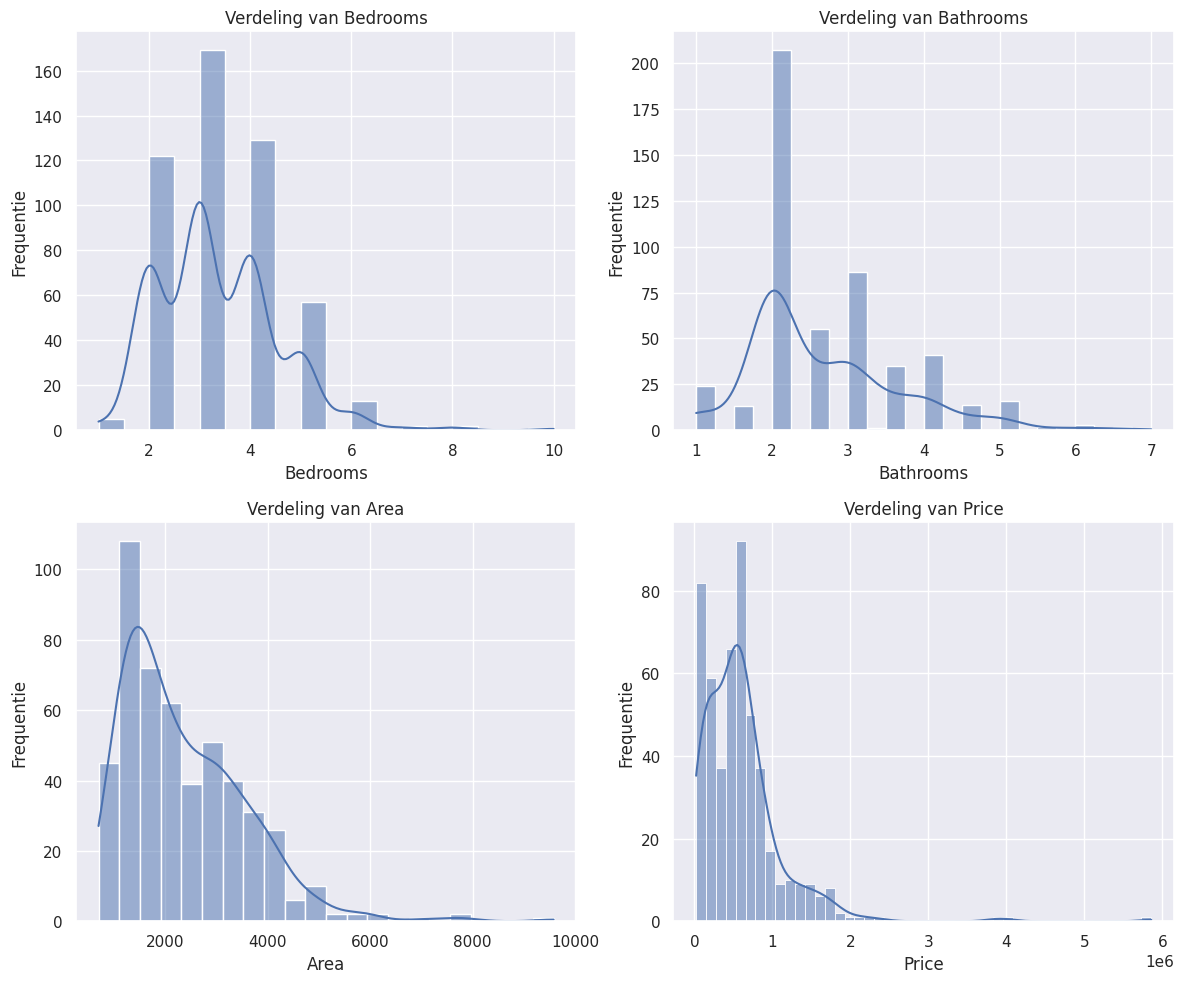

In [ ]:
kolommen = ['Bedrooms', 'Bathrooms', 'Area', 'Price']

sns.set(style="darkgrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rijen, 2 kolommen

# Histogrammen plotten in het raster
ax_index = 0
for rij in range(2):
    for kolom in range(2):
        sns.histplot(train_numeriek_df[kolommen[ax_index]], kde=True, ax=axes[rij, kolom])
        axes[rij, kolom].set_title(f'Verdeling van {kolommen[ax_index]}')
        axes[rij, kolom].set_xlabel(kolommen[ax_index])
        axes[rij, kolom].set_ylabel('Frequentie')
        ax_index += 1

plt.tight_layout()  # Ruimte tussen subplots aanpassen
plt.show()

# Er zijn halve waardes bij bathrooms. Die zijn dan misschien alleen toiletten of wasbakken

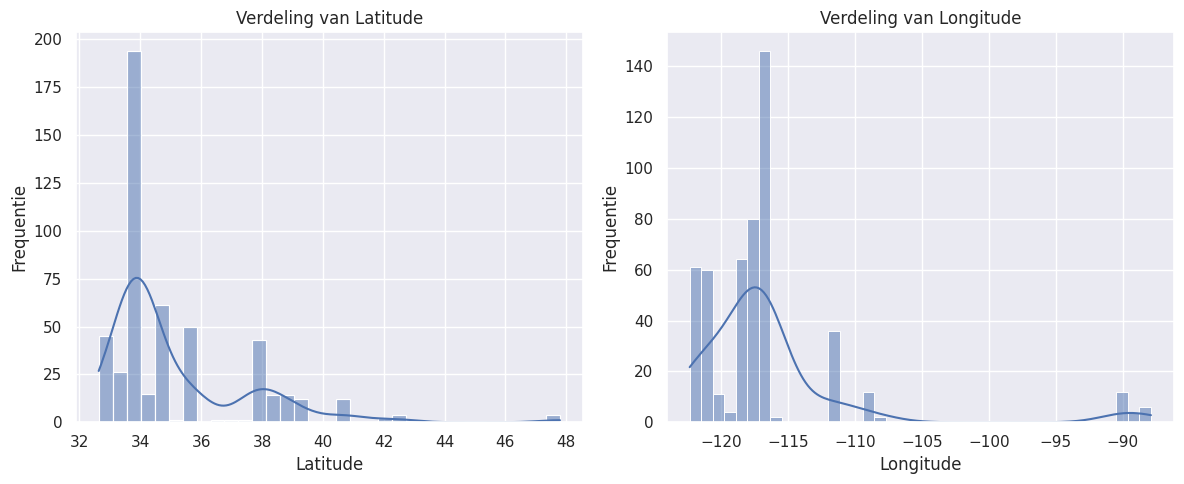

In [ ]:
# Plot histogram voor longtitude en latitude
sns.set(style="darkgrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 rij, 2 kolommen

# Histogrammen plotten in het raster
ax_index = 0
for kolom in ['Latitude', 'Longitude']:
    sns.histplot(train_numeriek_df[kolom], kde=True, ax=axes[ax_index])
    axes[ax_index].set_title(f'Verdeling van {kolom}')
    axes[ax_index].set_xlabel(kolom)
    axes[ax_index].set_ylabel('Frequentie')
    ax_index += 1

plt.tight_layout()  # Ruimte tussen subplots aanpassen
plt.show()

### Correlaties

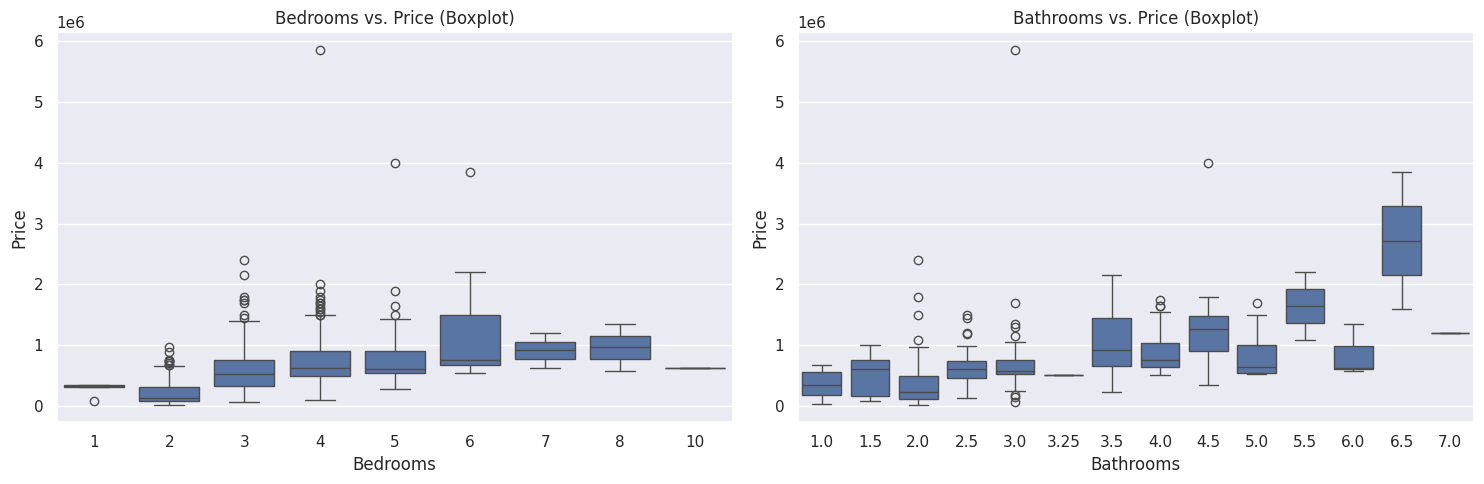

In [ ]:
kolommen = ['Bedrooms', 'Bathrooms']

fig, axes = plt.subplots(1, len(kolommen), figsize=(15, 5))

# Boxplots plotten
for i, kolom in enumerate(kolommen):
    sns.boxplot(x=kolom, y='Price', data=train_numeriek_df, ax=axes[i])
    axes[i].set_title(f'{kolom} vs. Price (Boxplot)')
    axes[i].set_xlabel(kolom)
    axes[i].set_ylabel('Price')

plt.tight_layout()
plt.show()

#### Bevindingen

**Bedrooms**: Er zit geen sterke lineare verband in deze grafiek. Het blijkt dat huizen met slaapkamers van 1 tot 6 wel een lineare correlatie hebben, maar na 6 slaapkamers verschillen de prijzen niet meer.  
**Bathrooms**: Er blijkt geen lineare verband te zijn in deze grafiek. Maar er is wel te zien dat "halve" badkamers een hogere prijs hebben vergeleken met alleen complete badkamers.  

In [ ]:
# Visualiseer en verwijder outliers
sns.boxplot(train_df["Price"])
plt.show()

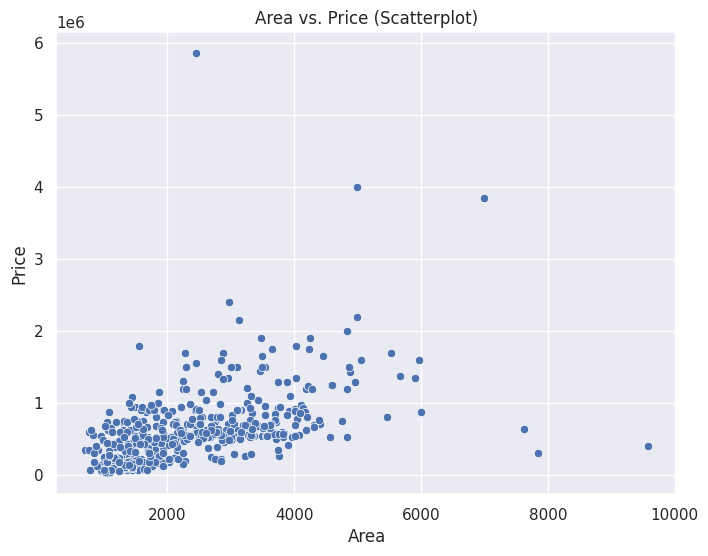

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Area', y='Price', data=train_numeriek_df)
plt.title('Area vs. Price (Scatterplot)')
plt.xlabel('Area')
plt.ylabel('Price')
plt.show()

**Area**: In deze grafiek is er wel een relatief linear verband. Het blijkt dat huizen met een grotere oppervlakte wel duurder zijn.

### Conclusie  
Over het algemeen lijkt woonoppervlakte de sterkste invloed te hebben op de huisprijs, terwijl het effect van slaapkamers en badkamers niet zo duidelijk is.

### Visualiseren

## Feature Engineering

In [14]:
# Wijzig de vorm van alle afbeeldingen na de lus
resized_train_images = []
for image in train_images:
    resized_image = tf.image.resize(image, (224, 224))  # Wijzig de gewenste vorm
    resized_train_images.append(resized_image)

### Data Preparation

In [ ]:
# Removing House ID, Longtitude and Altitude
train_numeriek_df_clean = train_numeriek_df.drop(['House ID', 'Longitude', 'Latitude'], axis=1)
test_numeriek_df_clean = test_numeriek_df.drop(['House ID', 'Longitude', 'Latitude'], axis=1)

#### Normalize

In [ ]:
# Normaliseer de hele dataset met MinMaxScaler
scaler = MinMaxScaler()
train_numeriek_df_clean = pd.DataFrame(scaler.fit_transform(train_numeriek_df_clean), columns=train_numeriek_df_clean.columns)
display(train_numeriek_df_clean)



,Bedrooms,Bathrooms,Area,Price
0,0.333333,0.500000,0.377392,0.145219
1,0.333333,0.333333,0.297456,0.144483
2,0.222222,0.500000,0.362756,0.148561
3,0.444444,0.666667,0.373902,0.152159
4,0.222222,0.500000,0.384485,0.162650
...,...,...,...,...
495,0.111111,0.166667,0.062599,0.061343
496,0.333333,0.166667,0.154357,0.069894
497,0.111111,0.166667,0.170232,0.096470
498,0.222222,0.250000,0.089957,0.050891


### Analysis

## Modeling

In [ ]:
X = train_numeriek_df_clean.drop('Price', axis=1)
y = train_numeriek_df_clean['Price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(train_numeriek_df_clean.shape[1]-1,)), # Input layer met 64 neuronen en ReLU activatie. -1 omdat price niet meegenomen moet worden.
    layers.Dense(32, activation='relu'), # Hidden layer met 32 neuronen en ReLU activatie.
    layers.Dense(1) # Output layer met 1 neuron voor de prijsvoorspelling.
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

# Evaluate
test_loss, test_mae = model.evaluate(X_val, y_val)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0468 - mae: 0.1531 - val_loss: 0.0037 - val_mae: 0.0471
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0084 - mae: 0.0564 - val_loss: 0.0045 - val_mae: 0.0576
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - mae: 0.0543 - val_loss: 0.0032 - val_mae: 0.0449
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - mae: 0.0462 - val_loss: 0.0032 - val_mae: 0.0461
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - mae: 0.0505 - val_loss: 0.0031 - val_mae: 0.0450
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mae: 0.0469 - val_loss: 0.0030 - val_mae: 0.0440
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - mae: 0.0475 - val_loss: 0.0030 - val_mae: 0.0448
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mae: 0.0473 - val_loss: 0.0029 - val_mae: 0.0442
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.00

In [ ]:
# Bereken de MAPE
y_pred = model.predict(X_val)
mape = mean_absolute_percentage_error(y_val, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Mean Absolute Percentage Error (MAPE): 207.54%


### Fully-connected neuraal netwerk

### Convolutioneel neuraal netwerk from scratch

Een Convolutioneel Neuraal Netwerk (CNN) is een speciaal type neuraal netwerk dat vooral wordt gebruikt voor het verwerken van afbeeldingen. CNN's zijn goed in taken zoals het herkennen van objecten en het classificeren van beelden. Ze werken door patronen in een afbeelding te zoeken met behulp van wiskundige berekeningen, zoals convoluties. Hierdoor kunnen ze vormen, randen en structuren herkennen, wat belangrijk is voor computer vision-toepassingen zoals gezichtsherkenning en zelfrijdende auto's.

[(Torres, 2023)](https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07)


#### Basisprincipes van CNN's


##### 1. Convolutie Laag (Convolution Layer)


De convolutielaag is een belangrijk onderdeel van een CNN. Het gebruikt een klein filter (ook wel kernel genoemd) om een afbeelding te analyseren en belangrijke kenmerken te herkennen.

- Filter: Een klein raster (bijvoorbeeld 3×3) dat over de afbeelding beweegt.

- Stapgrootte (Stride): Het aantal pixels dat het filter per keer opschuift.

- Padding: Extra pixels aan de randen van de afbeelding toevoegen om de afmetingen van de uitvoer te behouden.

[(Torres, 2023)](https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07)

[(GeeksforGeeks, 2024b)](https://www.geeksforgeeks.org/introduction-convolution-neural-network/
)


**Berekening:** Op elke positie wordt het filter vermenigvuldigd met het bijbehorende deel van de afbeelding. Daarna worden de resultaten opgeteld om een nieuw beeld te vormen.

##### 2. Pooling Laag (Pooling Layer)

Pooling is een techniek die helpt om de hoeveelheid gegevens in een afbeelding te verkleinen. Dit maakt het model sneller en minder gevoelig voor kleine veranderingen in de afbeelding.

- Max Pooling: Kiest de hoogste waarde in een klein gebied van de afbeelding.

- Average Pooling: Berekent het gemiddelde van de waarden in een klein gebied.

[(Torres, 2023)](https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07)

##### 3. Activatiefunctie (Activation Function)

Een activatiefunctie zorgt ervoor dat een neuraal netwerk complexe patronen kan leren door niet-lineariteit toe te voegen. Een veelgebruikte activatiefunctie is ReLU (Rectified Linear Unit), die negatieve waarden naar nul omzet en positieve waarden doorlaat.


[(GeeksforGeeks, 2024b)](https://www.geeksforgeeks.org/introduction-convolution-neural-network/)


##### 4. Fully Connected Layer (Volledig verbonden laag)

Deze laag zorgt voor de classificatie op basis van de kenmerken die in de vorige lagen zijn gevonden. Terwijl convolutie- en poolinglagen vaak de ReLU-activeringsfunctie gebruiken, maakt de volledig verbonden laag (fully connected layer) gebruik van de Softmax-functie. Deze functie zet de uitkomsten om in waarschijnlijkheden tussen 0 en 1, zodat het netwerk kan voorspellen tot welke klasse een invoer behoort.


[(Torres, 2023)](https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07)


[(IBM. (z.d.))](https://www.ibm.com/think/topics/convolutional-neural-networks)

#### Regularisatie in Convolutionele Neurale Netwerken


**L1-regularisatie (Lasso):** Hierbij wordt de absolute waarde van de gewichten opgeteld bij de verliesfunctie. Dit zorgt ervoor dat sommige gewichten precies nul worden, waardoor minder belangrijke parameters verdwijnen. Het resultaat is een eenvoudiger model met minder filters.

$$
\text{Loss} = \text{lossfunctie} + \lambda \sum |β_i|
$$

**L2-regularisatie (Ridge, Weight Decay):** Deze methode telt de kwadraten van de gewichten op bij de verliesfunctie. Hierdoor blijven de gewichten klein en worden extreme waarden voorkomen. Dit helpt het model stabieler en minder gevoelig voor overfitting te maken.

$$
\text{Loss} = \text{lossfunctie} + \lambda \sum β_i^2
$$


[(Tewari, 2024)](https://medium.com/analytics-vidhya/regularization-understanding-l1-and-l2-regularization-for-deep-learning-a7b9e4a409bf)



**Dropout** is een techniek om overfitting te voorkomen in diepe neurale netwerken. Tijdens het trainen worden willekeurig sommige uitgangen van een laag genegeerd ("dropout"). Hierdoor leert het model minder afhankelijk te zijn van specifieke neuronen en wordt het robuuster.

[(GeeksforGeeks, 2024a)](https://www.geeksforgeeks.org/dropout-regularization-in-deep-learning/
)


Batch normalisatie zorgt ervoor dat een CNN sneller en stabieler traint door de activaties per batch te normaliseren. Dit voorkomt dat waarden te groot of te klein worden en helpt het netwerk beter om te gaan met variaties in de invoerdata. Hierdoor kan het model efficiënter leren.



[(Wikipedia contributors, 2024b)](https://en.wikipedia.org/wiki/Batch_normalization#:~:text=December%202021),and%20Christian%20Szegedy%20in%202015.)

Data-augmentatie is een manier om overfitting te verminderen bij CNN’s. Door de trainingsdata te variëren met technieken zoals roteren, schalen, spiegelen en vervormen, leert het model robuustere en algemenere kenmerken. Dit helpt het netwerk beter om te gaan met nieuwe, onbekende afbeeldingen.

[(IBM. (z.d.))](https://www.ibm.com/think/topics/data-augmentation)


#### Hoe kies je de beste regularisatie?

De keuze voor regularisatie hangt af van het doel van je model. L1-regularisatie is handig als je een eenvoudiger model met minder parameters wilt, terwijl L2-regularisatie beter is als je alle features wilt behouden maar hun invloed wilt beperken. Data-augmentatie is vooral nuttig bij beeldherkenning en deep learning, omdat het variatie in de trainingsdata toevoegt en zo de generalisatie verbetert. Dropout werkt goed in diepe neurale netwerken, vooral bij grote modellen, omdat het willekeurig neuronen uitschakelt tijdens training en zo overfitting tegengaat.

[(Olamendy, 2024)](https://medium.com/@juanc.olamendy/a-comprehensive-guide-to-regularization-in-machine-learning-9d1243002c50)

Een kolom 'filename' wordt toegevoegd aan de DataFrame train_numeriek_df, waarin het bestandspad van elke afbeelding wordt gegenereerd op basis van de 'House ID'.

In [49]:
# Genereert een nieuwe kolom 'filename'
train_numeriek_df['filename'] = train_numeriek_df['House ID'].apply(lambda x: f"{img_train_directory}/{x}.jpg")

# Controleer of de bestanden bestaan
invalid_files = []
for file_path in train_numeriek_df['filename']:
    if not os.path.exists(file_path):
        invalid_files.append(file_path)

if invalid_files:
    print(f"Aantal ongeldige bestanden: {len(invalid_files)}")
    print("Voorbeelden van ongeldige bestanden:", invalid_files[:5])
else:
    print("Alle bestanden zijn geldig.")


Alle bestanden zijn geldig.


De dataset train_numeriek_df wordt opgesplitst in een trainingset (80%) en een validatieset (20%), waarbij random_state=42 zorgt voor reproduceerbaarheid.

In [103]:
# Split in train/validation
train_df = train_numeriek_df.sample(frac=0.8, random_state=42)
val_df = train_numeriek_df.drop(train_df.index)


In [66]:
train_df["Price"] = np.log1p(train_df["Price"])
val_df["Price"] = np.log1p(val_df["Price"])

De prijzen in zowel de trainings- als validatieset worden genormaliseerd door elke waarde te delen door de maximale prijs in de dataset.

In [67]:
train_df['Price'] = train_df['Price'] / train_df['Price'].max()
val_df['Price'] = val_df['Price'] / val_df['Price'].max()

Een data-augmentatiepipeline wordt ingesteld voor de trainingsset, waarbij afbeeldingen worden geschaald en willekeurig getransformeerd. De validatieset wordt alleen geschaald. Vervolgens worden generators aangemaakt om de afbeeldingen en bijbehorende prijzen in batches te laden voor modeltraining.

In [69]:
# Data augmentation voor training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    zoom_range=0.2
)

# Alleen rescaling voor validatie
val_datagen = ImageDataGenerator(rescale=1./255)

# ImageDataGenerator voor rescaling van afbeeldingen
# train_datagen = ImageDataGenerator(rescale=1./255)
# val_datagen = ImageDataGenerator(rescale=1./255)


# Train generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='Price',
    target_size=(256, 256),
    class_mode='raw',
    batch_size=32,
    shuffle=True  # Zorg dat de batches worden geschud
)

# Validation generator
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='Price',
    target_size=(256, 256),
    class_mode='raw',
    batch_size=32,
    shuffle=False  #
)


Found 400 validated image filenames.
Found 100 validated image filenames.


In [70]:
# Definieer het CNN-model
model = Sequential([
    Input(shape=(256, 256, 3)),  # Gebruik een aparte Input-laag
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1)  # Output laag voor regressie
])

# Compileer het model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])

# Early Stopping om overfitting te voorkomen
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Samenvatting van het model
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,079,553 (99.49 MB)

 Trainable params: 26,079,553 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
# Train het model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    verbose=1
)

# Evalueer het model op de validatiedata
loss, mae = model.evaluate(validation_generator)
print(f"Validation Loss (MSE): {loss}")
print(f"Validation MAE: {mae}")

# Voorspel de waarden voor de validatiedata
y_pred = model.predict(validation_generator)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 223.0156 - mae: 6.9252 - val_loss: 1.5834 - val_mae: 0.4407
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 965ms/step - loss: 1.5643 - mae: 0.3208 - val_loss: 1.5240 - val_mae: 0.2852
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 994ms/step - loss: 1.4883 - mae: 0.2037 - val_loss: 1.4332 - val_mae: 0.2350
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 978ms/step - loss: 1.3999 - mae: 0.1725 - val_loss: 1.3602 - val_mae: 0.2528
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 1.3221 - mae: 0.1738 - val_loss: 1.2932 - val_mae: 0.2641
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 983ms/step - loss: 1.2442 - mae: 0.1589 - val_loss: 1.2474 - val_mae: 0.2918
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 1.1857 - mae: 0.1593 - val_loss: 1.1768 - val_mae: 0.2561
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 1.1381 - mae: 0.1626 - val_loss: 1.1012 - val_mae: 0.1823
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 

In [104]:

# Selecteer kolommen voor normalisatie
# columns_to_normalize = ['Price']

# Normaliseer alleen de geselecteerde kolommen
# scaler = MinMaxScaler()
# train_df[columns_to_normalize] = scaler.fit_transform(train_df[columns_to_normalize])
# val_df[columns_to_normalize] = scaler.transform(val_df[columns_to_normalize])

# ImageDataGenerator voor rescaling van afbeeldingen
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col="filename", y_col="Price",
    target_size=(256, 256), batch_size=32, class_mode="raw")

validation_generator = val_datagen.flow_from_dataframe(
    val_df, x_col="filename", y_col="Price",
    target_size=(256, 256), batch_size=32, class_mode="raw")

# ======= 2. Model Architectuur =======
model = Sequential([
    Input(shape=(256, 256, 3)),  # Voeg expliciet een Input laag toe
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='linear')
])
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# ======= 3. Compileer het model =======
lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss="mean_absolute_percentage_error",  # Gebruik MAPE als loss-functie
              metrics=['mae'])

# Early Stopping voor betere training
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# ======= 4. Train het model =======
history = model.fit(
    train_generator,
    epochs=100,  # Meer epochs voor betere training
    validation_data=validation_generator,
    callbacks=[early_stopping],
    verbose=1
)

# ======= 5. Model Evaluatie =======
loss, mae = model.evaluate(validation_generator)
print(f"Validation Loss (MAPE): {loss}")
print(f"Validation MAE: {mae}")

# ======= 6. Voorspellingen =======
y_pred = model.predict(validation_generator)


Found 400 validated image filenames.
Found 100 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 100.8803 - mae: 651741.5625 - val_loss: 91.2475 - val_mae: 492197.4375
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 492ms/step - loss: 82.2074 - mae: 555344.0000 - val_loss: 79.4560 - val_mae: 458625.8750
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 524ms/step - loss: 76.4020 - mae: 527130.0000 - val_loss: 68.2155 - val_mae: 399226.2812
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 579ms/step - loss: 70.5106 - mae: 482325.7500 - val_loss: 66.9295 - val_mae: 379537.2812
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 458ms/step - loss: 72.6515 - mae: 472115.6875 - val_loss: 68.6069 - val_mae: 408029.4062
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 608ms/step - loss: 71.1631 - mae: 544525.8125 - val_loss: 66.0049 - val_mae: 374928.8125
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 465ms/step - loss: 70.7747 - mae: 489320.8750 - val_loss: 66.6758 - val_mae: 388145.3125
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 471ms/step - loss: 73.6894 - mae: 47261

### Transfer learning

### Multimodaal mode

## Results

### Overview

### Scores

## Conclusion & Advice

In [ ]:
# test_numeriek_df

In [91]:
import numpy as np
import pandas as pd

def submission(pred, test_df, filename):
    """
    Creates a submission file for a prediction.

    Args:
        pred (np.ndarray): The predictions.
        test_df (pd.DataFrame): The test dataframe.
        filename (str): The filename of the submission file (must include .csv extension).

    Returns:
        pd.DataFrame: The submission dataframe.
    """
    # Ensure pred is a 1D array and has the same length as test_df
    pred = pred.reshape(-1)  # Flatten if necessary
    pred = pred[:len(test_df)]  # Truncate to match test_df length

    # Create the submission DataFrame
    df = pd.DataFrame({'House ID': test_df['House ID'], 'Price': pred})

    # Save the DataFrame to a CSV file
    df_n = df.to_csv(filename, index=False)

    # Return the DataFrame (optional)
    return df_n

In [105]:
submission(y_pred, test_numeriek_df, 'CNN12.csv')

## Sources

- Torres, L. F. (2023, 23 november). Convolutional Neural Network From Scratch - LatinXInAI - Medium. Medium. https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07

- GeeksforGeeks. (2024b, oktober 10). Introduction to Convolution Neural Network. GeeksforGeeks. https://www.geeksforgeeks.org/introduction-convolution-neural-network/

- IBM. (z.d.). Convolutional neural networks. IBM. https://www.ibm.com/think/topics/convolutional-neural-networks

- Tewari, U. (2024, 19 januari). Regularization — Understanding L1 and L2 regularization for Deep Learning. Medium. https://medium.com/analytics-vidhya/regularization-understanding-l1-and-l2-regularization-for-deep-learning-a7b9e4a409bf

- GeeksforGeeks. (2024a, maart 26). Dropout regularization in deep learning. GeeksforGeeks. https://www.geeksforgeeks.org/dropout-regularization-in-deep-learning/

- Wikipedia contributors. (2024b, december 25). Batch normalization. Wikipedia. https://en.wikipedia.org/wiki/Batch_normalization#:~:text=December%202021),and%20Christian%20Szegedy%20in%202015.

- Olamendy, J. C. (2024, 28 november). A Comprehensive Guide to Regularization in Machine Learning. Medium. https://medium.com/@juanc.olamendy/a-comprehensive-guide-to-regularization-in-machine-learning-9d1243002c50

- IBM. (z.d.). Data augmentation. https://www.ibm.com/think/topics/data-augmentation